# 16 - Adding Formation Data to a Well Log Plot
**Created by: Andy McDonald**  
Link to article: https://andymcdonaldgeo.medium.com/adding-formation-data-to-a-well-log-plot-3897b96a3967

Well log plots are a common visualization tool within geoscience and petrophysics. They allow easy visualization of data (for example, Gamma Ray, Neutron Porosity, Bulk Density, etc) that has been acquired along the length (depth) of a wellbore.

I have previously covered different aspects of making these plots in the following articles:
- [Loading Multiple Well Log LAS Files Using Python
](https://towardsdatascience.com/loading-multiple-well-log-las-files-using-python-39ac35de99dd)
- [Displaying Logging While Drilling (LWD) Image Logs in Python](https://towardsdatascience.com/displaying-logging-while-drilling-lwd-image-logs-in-python-4babb6e577ba)
- [Enhancing Visualization of Well Logs With Plot Fills](https://towardsdatascience.com/enhancing-visualization-of-well-logs-with-plot-fills-72d9dcd10c1b)
- [Loading and Displaying Well Log Data](https://andymcdonaldgeo.medium.com/loading-and-displaying-well-log-data-b9568efd1d8)

In this article, I will show how to combine these different methods into a single plot function allow you to easily reuse the code with similar data. 


For the examples below you can find my Jupyter Notebook and dataset on my GitHub repository at the following link.

https://github.com/andymcdgeo/Petrophysics-Python-Series

## Creating a Reusable Log Plot and Showing Formation Data
### Setting up the Libraries
For this article and notebook we will be using a number of different libraries. 
We will be using five libraries: pandas, matplotlib, csv, collecitons, and lasio. Pandas and lasio, will be used to load and store the log data, collections allow us to use a defaultdict to load in our formation tops to a dictionary. Finally, matplotlib will let us plot out well log data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import lasio as las
import csv
from collections import defaultdict
import numpy as np

### Loading LAS Data
The first set of data we will load will be the LAS file from the Volve datset. To do this we call upon the las.read() function and pass in the file. Once the file has been read, we can convert it quickly to a pandas dataframe using .df(). This will make it easier for us to work with. 

To see how to load multiple las files, check out my previous article [here](https://towardsdatascience.com/loading-multiple-well-log-las-files-using-python-39ac35de99dd).

In [2]:
data = las.read('Data/15-9-19_SR_COMP.las')
well = data.df()

When lasio converts the las file to a dataframe it assigns the depth curve as the dataframe index. This can be converted to a column as seen below. This is especially important when we are working with multiple las files and we do not wish to cause clashes with similar depth values.

In [3]:
well['DEPTH'] = well.index

We can then print the header of the dataframe to verify our data has loaded correctly.

In [4]:
well.head()

,AC,CALI,DEN,GR,NEU,RDEP,RMED,DEPTH
DEPT,,,,,,,,
102.1568,NaN,NaN,NaN,5.3274,NaN,NaN,NaN,102.1568
102.3092,NaN,NaN,NaN,5.8235,NaN,NaN,NaN,102.3092
102.4616,NaN,NaN,NaN,6.5228,NaN,NaN,NaN,102.4616
102.6140,NaN,NaN,NaN,7.2285,NaN,NaN,NaN,102.6140
102.7664,NaN,NaN,NaN,9.5020,NaN,NaN,NaN,102.7664


### Loading Formation Tops
For this article, three formation tops are stored within a simple csv file. For each formation, the top and bottom depth are stored. To load this file in, we can use the code snippet below.

In [5]:
formations_dict= {}

In [6]:
with open('Data/Formations/15_9_19_SR_Formations.csv', 'r') as file:
    next(file) #skip header row
    for row in csv.DictReader(file, fieldnames=['Formation', 'Top', 'Bottom']):
        formations_dict[row['Formation']]=[float(row['Top']), float(row['Bottom'])]
    

When we call formations_dict we can preview what our dictionary contains.

In [7]:
formations_dict

{'Hugin Fm.': [4316.5, 4340.0],
 'Skagerrak': [4340.0, 4579.0],
 'Smith Bank Fm.': [4579.0, 4641.0]}

In [8]:
formations_dict['Hugin Fm.'][0]

4316.5

In order for the tops to be plotted in the correct place on a log plot we need to calculate the midpoint between the formation top and bottom depths. As the depth values are in list form, they can be called using the index number, with 0 being the top depth and 1 being the bottom depth.

In [9]:
formation_midpoints = []
for key, value in formations_dict.items():
    formation_midpoints.append(value[0] + (value[1]-value[0])/2)
    
formation_midpoints

[4328.25, 4459.5, 4610.0]

Finally, we can assign some colors to our formations. in this case I have selected red, blue, and green.

In [10]:
# Select the same number of colors as there are formations
zone_colors = ["red", "blue", "green"]

### Setting up the Log Plot
In my previous articles, I created the plots on the fly and the code was only usable for a particular dataset. Generalizing a well log plot or petrophysics plot can be difficult due to the variety of curve mnemonics and log plot setups. In this example, I have placed my plotting section within a function.

Using functions is a great way to increase the reusability of code and reduces the amount of duplication that can occur.

Below the following code snippet, I have explained some of the key sections that make up our well log plot function.

In [11]:
def makeplot(depth, gamma, res, neut, dens, dtc, formations, topdepth, bottomdepth,
            colors):
    fig, ax = plt.subplots(figsize=(15,10))

    #Set up the plot axes
    ax1 = plt.subplot2grid((1,10), (0,0), rowspan=1, colspan = 3)
    ax2 = plt.subplot2grid((1,10), (0,3), rowspan=1, colspan = 3, sharey = ax1)
    ax3 = plt.subplot2grid((1,10), (0,6), rowspan=1, colspan = 3, sharey = ax1)
    ax4 = ax3.twiny() 
    ax5 = plt.subplot2grid((1,10), (0,9), rowspan=1, colspan = 1, sharey = ax1)

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    ax10 = ax1.twiny()
    ax10.xaxis.set_visible(False)
    ax11 = ax2.twiny()
    ax11.xaxis.set_visible(False)
    ax12 = ax3.twiny()
    ax12.xaxis.set_visible(False)

    # Gamma Ray track
    
    ## Setting up the track and curve
    ax1.plot(gamma, depth, color = "green", linewidth = 0.5)
    ax1.set_xlabel("Gamma")
    ax1.xaxis.label.set_color("green")
    ax1.set_xlim(0, 150)
    ax1.set_ylabel("Depth (m)")
    ax1.tick_params(axis='x', colors="green")
    ax1.spines["top"].set_edgecolor("green")
    ax1.title.set_color('green')
    ax1.set_xticks([0, 50, 100, 150])
    ax1.text(0.05, 1.04, 0, color='green', 
             horizontalalignment='left', transform=ax1.transAxes)
    ax1.text(0.95, 1.04, 150, color='green', 
             horizontalalignment='right', transform=ax1.transAxes)
    ax1.set_xticklabels([])
    
    ## Setting Up Shading for GR
    left_col_value = 0
    right_col_value = 150
    span = abs(left_col_value - right_col_value)
    cmap = plt.get_cmap('hot_r')
    color_index = np.arange(left_col_value, right_col_value, span / 100)
    #loop through each value in the color_index
    for index in sorted(color_index):
        index_value = (index - left_col_value)/span
        color = cmap(index_value) #obtain color for color index value
        ax1.fill_betweenx(depth, gamma , right_col_value, where = gamma >= index,  color = color)
    
    
    
    # Resistivity track
    ax2.plot(res, depth, color = "red", linewidth = 0.5)
    ax2.set_xlabel("Resistivity")
    ax2.set_xlim(0.2, 2000)
    ax2.xaxis.label.set_color("red")
    ax2.tick_params(axis='x', colors="red")
    ax2.spines["top"].set_edgecolor("red")
    ax2.set_xticks([0.1, 1, 10, 100, 1000])
    ax2.semilogx()
    ax2.text(0.05, 1.04, 0.1, color='red', 
             horizontalalignment='left', transform=ax2.transAxes)
    ax2.text(0.95, 1.04, 1000, color='red', 
             horizontalalignment='right', transform=ax2.transAxes)
    ax2.set_xticklabels([])

    # Density track
    ax3.plot(dens, depth, color = "red", linewidth = 0.5)
    ax3.set_xlabel("Density")
    ax3.set_xlim(1.95, 2.95)
    ax3.xaxis.label.set_color("red")
    ax3.tick_params(axis='x', colors="red")
    ax3.spines["top"].set_edgecolor("red")
    ax3.set_xticks([1.95, 2.45, 2.95])
    ax3.text(0.05, 1.04, 1.95, color='red', 
             horizontalalignment='left', transform=ax3.transAxes)
    ax3.text(0.95, 1.04, 2.95, color='red', 
             horizontalalignment='right', transform=ax3.transAxes)
    ax3.set_xticklabels([])


    # Neutron track placed ontop of density track
    ax4.plot(neut, depth, color = "blue", linewidth = 0.5)
    ax4.set_xlabel('Neutron')
    ax4.xaxis.label.set_color("blue")
    ax4.set_xlim(45, -15)
    ax4.tick_params(axis='x', colors="blue")
    ax4.spines["top"].set_position(("axes", 1.08))
    ax4.spines["top"].set_visible(True)
    ax4.spines["top"].set_edgecolor("blue")
    ax4.set_xticks([45,  15, -15])
    ax4.text(0.05, 1.1, 45, color='blue', 
             horizontalalignment='left', transform=ax4.transAxes)
    ax4.text(0.95, 1.1, -15, color='blue', 
              horizontalalignment='right', transform=ax4.transAxes)
    ax4.set_xticklabels([])

    ax5.set_xticklabels([])
    ax5.text(0.5, 1.1, 'Formations', fontweight='bold',
             horizontalalignment='center', transform=ax5.transAxes)
    
    # Adding in neutron density shading
    x1=dens
    x2=neut

    x = np.array(ax3.get_xlim())
    z = np.array(ax4.get_xlim())

    nz=((x2-np.max(z))/(np.min(z)-np.max(z)))*(np.max(x)-np.min(x))+np.min(x)

    ax3.fill_betweenx(depth, x1, nz, where=x1>=nz, interpolate=True, color='green')
    ax3.fill_betweenx(depth, x1, nz, where=x1<=nz, interpolate=True, color='yellow')
    
    
    # Common functions for setting up the plot can be extracted into
    # a for loop. This saves repeating code.
    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(bottomdepth, topdepth)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))
    
    for ax in [ax1, ax2, ax3, ax5]:
        # loop through the formations dictionary and zone colors
        for depth, color in zip(formations.values(), colors):
            # use the depths and colors to shade across the subplots
            ax.axhspan(depth[0], depth[1], color=color, alpha=0.1)


    for ax in [ax2, ax3, ax4, ax5]:
        plt.setp(ax.get_yticklabels(), visible = False)
    
    for label, formation_mid in zip(formations_dict.keys(), 
                                    formation_midpoints):
        ax5.text(0.5, formation_mid, label, rotation=90,
                verticalalignment='center', fontweight='bold',
                fontsize='large')

    plt.tight_layout()
    fig.subplots_adjust(wspace = 0)

**Lines 3–10** sets up the log tracks. Here, I am using subplot2grid to control the number of tracks. suplot2grid((1,10), (0,0), rowspan=1, colspan=3) translates to creating a plot that is 10 columns wide, 1 row high and the first few axes spans 3 columns each. This allows us to control the width of each track.

The last track (ax5) will be used to plot our formation tops information.

```python
    fig, ax = plt.subplots(figsize=(15,10))
    #Set up the plot axes
    ax1 = plt.subplot2grid((1,10), (0,0), rowspan=1, colspan = 3)
    ax2 = plt.subplot2grid((1,10), (0,3), rowspan=1, colspan = 3, sharey = ax1)
    ax3 = plt.subplot2grid((1,10), (0,6), rowspan=1, colspan = 3, sharey = ax1)
    ax4 = ax3.twiny() 
    ax5 = plt.subplot2grid((1,10), (0,9), rowspan=1, colspan = 1, sharey = ax1)
```

**Lines 14–19** adds a second set of the axis on top of the existing one. This allows maintaining a border around each track when we come to detach the scale.

```python
    ax10 = ax1.twiny()
    ax10.xaxis.set_visible(False)
    ax11 = ax2.twiny()
    ax11.xaxis.set_visible(False)
    ax12 = ax3.twiny()
    ax12.xaxis.set_visible(False)
```

**Lines 21–49** set up the gamma ray track. First, we use ax1.plot to set up the data, line width, and color. Next, we set up the x-axis with a label, an axis color, and a set of limits. 

As ax1 is going to be the first track on the plot, we can assign the y axis label of Depth (m).

After defining the curve setup, we can add some colored fill between the curve and the right-hand side of the track. See Enhancing Visualization of Well Logs with Plot Fills for details on how this was setup.

```python
    # Gamma Ray track

    ## Setting up the track and curve
    ax1.plot(gamma, depth, color = "green", linewidth = 0.5)
    ax1.set_xlabel("Gamma")
    ax1.xaxis.label.set_color("green")
    ax1.set_xlim(0, 150)
    ax1.set_ylabel("Depth (m)")
    ax1.tick_params(axis='x', colors="green")
    ax1.spines["top"].set_edgecolor("green")
    ax1.title.set_color('green')
    ax1.set_xticks([0, 50, 100, 150])
    ax1.text(0.05, 1.04, 0, color='green', 
             horizontalalignment='left', transform=ax1.transAxes)
    ax1.text(0.95, 1.04, 150, color='green', 
             horizontalalignment='right', transform=ax1.transAxes)
    ax1.set_xticklabels([])
    
    ## Setting Up Shading for GR
    left_col_value = 0
    right_col_value = 150
    span = abs(left_col_value - right_col_value)
    cmap = plt.get_cmap('hot_r')
    color_index = np.arange(left_col_value, right_col_value, span / 100)
    #loop through each value in the color_index
    for index in sorted(color_index):
        index_value = (index - left_col_value)/span
        color = cmap(index_value) #obtain color for color index value
        ax1.fill_betweenx(depth, gamma , right_col_value, where = gamma >= index,  color = color)
```

        
In my previous articles with log plots, there have been gaps between each of the tracks. When this gap was reduced the scale information for each track became muddled up. A better solution for this is to turn of the axis labels using ax1.set_xticklabels([]) and use a text label like below. 

```python
    ax1.text(0.05, 1.04, 0, color='green', 
             horizontalalignment='left', transform=ax1.transAxes)
    ax1.text(0.95, 1.04, 150, color='green', 
             horizontalalignment='right', transform=ax1.transAxes)
```

The ax.text function can take in a number of arguments, but the basics are ax.text(xposition, yposition, textstring). In our example, we also pass in the horizontal alignment and a transform argument.

We then repeat this for each axis, until ax5, where all we need to do is add a track header and hide the x ticks.

Note that ax4 is twinned with ax3 and sits on top of it. This allows easy plotting of the neutron porosity data.

**Lines 103–113** contain the code for setting up the fill between the neutron porosity and density logs. See Enhancing Visualization of Well Logs with Plot Fills for details on this method.


```python
    ax5.set_xticklabels([])
    ax5.text(0.5, 1.1, 'Formations', fontweight='bold',
             horizontalalignment='center', transform=ax5.transAxes)
```

In **Lines 118–123** we can save some lines of code by bundling common functions we want to apply to each track into a single for loop and allows us to set parameters for the axes in one go.

In this loop we are:
- setting the y axis limits to the bottom and top depth we supply to the function
- setting the grid line style
- setting the position of the x axis label and tick marks
- offsetting the top part (spine) of the track so it floats above the track

    ```python
    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(bottomdepth, topdepth)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))
    ```

**Lines 125–129** contains the next for loop that applies to ax1, ax2, ax3, and ax5 and lets us add formation shading across all tracks. We can loop through a zipped object of our formation depth values in our formations_dict and the zone_colours list. We will use these values to create a horizontal span object using ax.axhspan. Basically, it adds a rectangle on top of our axes between two Y-values (depths).

```python
    for ax in [ax1, ax2, ax3, ax5]:
        # loop through the formations dictionary and zone colors
        for depth, color in zip(formations.values(), colors):
            # use the depths and colors to shade across subplots
            ax.axhspan(depth[0], depth[1], color=color, alpha=0.1)
```
            
**Lines 132–133** hides the yticklabels (depth labels) on each of the tracks (subplots).

```python
    for ax in [ax2, ax3, ax4, ax5]:
        plt.setp(ax.get_yticklabels(), visible = False)
```
        
**Lines 135–139** is our final and key for loop for adding our formation labels directly onto ax5. Here we are using the ax.text function and passing in an x position (0.5 = middle of the track) and a y position, which is our calculated formation midpoint depths. We then want to align the text vertically from the center so that the center of the text string sits in the middle of the formation.

```python
    for label, formation_mid in zip(formations_dict.keys(), 
                                    formation_midpoints):
        ax5.text(0.5, formation_mid, label, rotation=90,
                verticalalignment='center', fontweight='bold',
                fontsize='large')
```

## Creating the Plot With Our Data
Now that our function is setup the way want it, we can now pass in the columns from the well dataframe. The power of the function comes into its own when we use other wells to make plots that are set up the same.

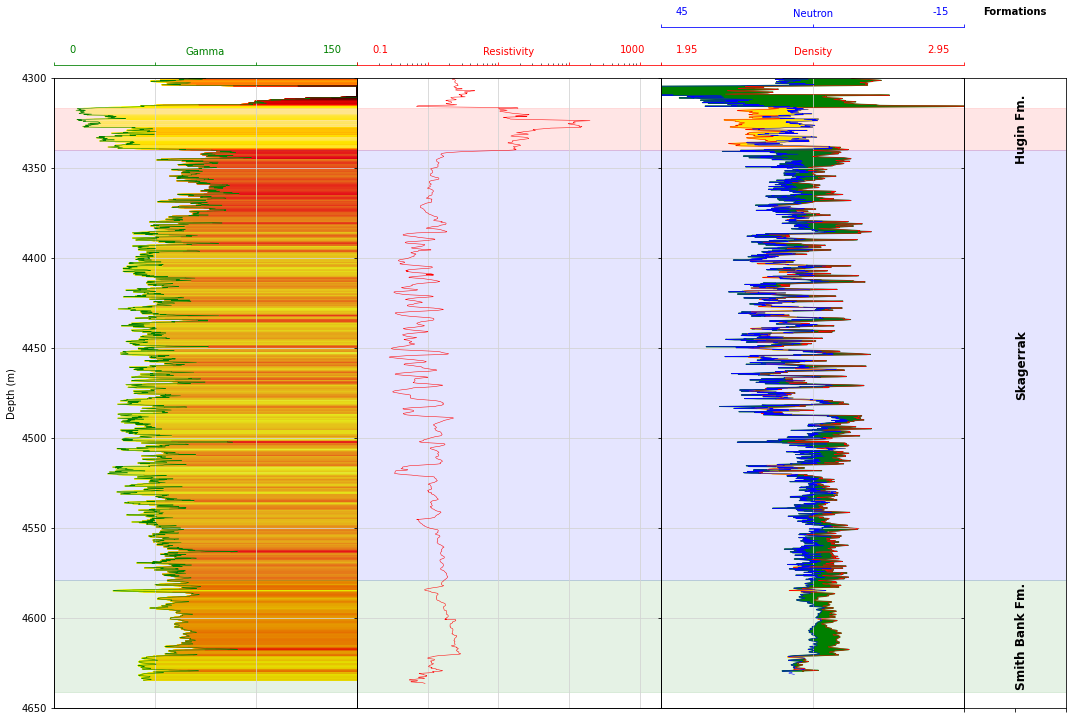

In [12]:
makeplot(well['DEPTH'], well['GR'], well['RDEP'], well['NEU'],
        well['DEN'], well['AC'], formations_dict, 4300, 4650, 
         zone_colors)

### Summary
In this article, we have covered how to load a las file and formation data from a csv file. This data was then plotted on our log plot. Also, we have seen how to turn our log plot code into a function, which allows us to reuse the code with other wells. This makes future plotting much simpler and quicker.

***Thanks for reading!***

*If you have found this article useful, please feel free to check out my other articles looking at various aspects of Python and well log data. You can also find my code used in this article and others at GitHub.*

*If you want to get in touch you can find me on LinkedIn or at my website.*

*Interested in learning more about python and well log data or petrophysics? Follow me on [Medium](https://medium.com/@andymcdonaldgeo).*